In [1]:
import torch
from config import *
from glob import glob
from src.model import *
from src.camvid_pipeline import *
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from matplotlib import pyplot as plt
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
train_images = sorted(glob('/home/ubuntu/vision-benchmark-datasets/camvid/train/*'))
train_labels = sorted(glob('/home/ubuntu/vision-benchmark-datasets/camvid/trainannot/*'))
val_images = sorted(glob('/home/ubuntu/vision-benchmark-datasets/camvid/val/*'))
val_labels = sorted(glob('/home/ubuntu/vision-benchmark-datasets/camvid/valannot/*'))
test_images = sorted(glob('/home/ubuntu/vision-benchmark-datasets/camvid/test/*'))
test_labels = sorted(glob('/home/ubuntu/vision-benchmark-datasets/camvid/testannot/*'))

In [4]:
train_dataset = CamVidDataset(train_images, train_labels, 512, 512)
val_dataset = CamVidDataset(val_images, val_labels, 512, 512)
test_dataset = CamVidDataset(test_images, test_labels, 512, 512)

In [5]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=4)

In [6]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([16, 3, 512, 512]), torch.Size([16, 512, 512]))

In [7]:
enet = Enet(12)
enet = enet.to(device)

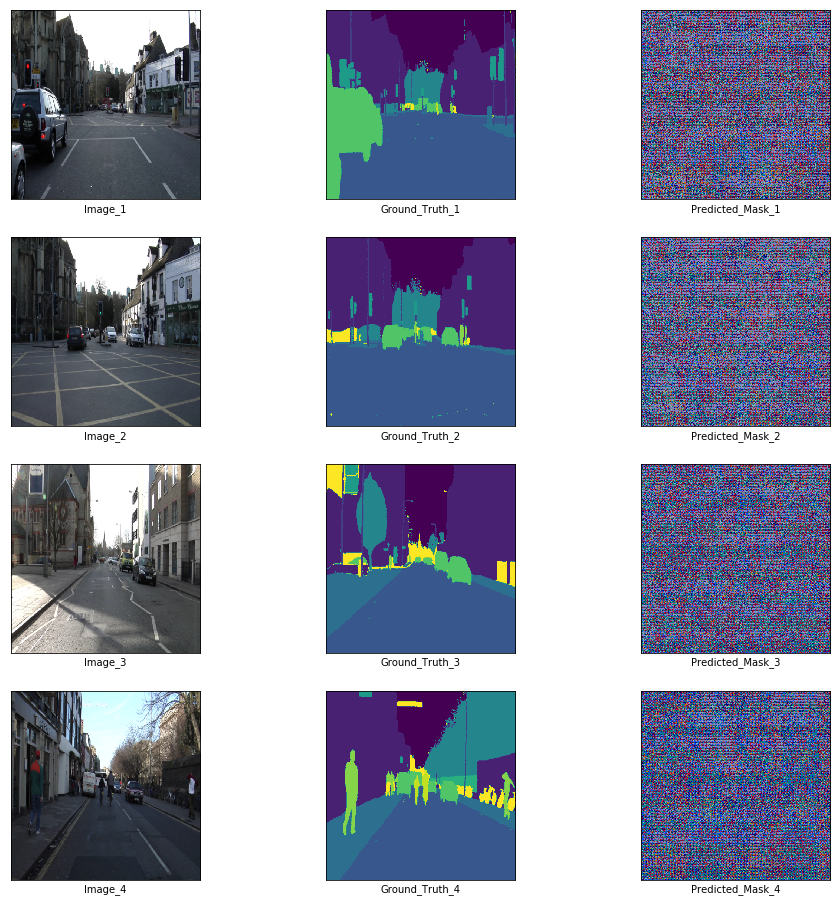

In [8]:
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (16, 16))
plt.setp(axes.flat, xticks = [], yticks = [])
c = 1
for i, ax in enumerate(axes.flat):
    if i % 3 == 0:
        ax.imshow(ToPILImage()(x_batch[c]))
        ax.set_xlabel('Image_' + str(c))
    elif i % 3 == 1:
        ax.imshow(y_batch[c])
        ax.set_xlabel('Ground_Truth_' + str(c))
    elif i % 3 == 2:
        ax.imshow(predict_rgb(enet, x_batch[c].unsqueeze(0).to(device)))
        ax.set_xlabel('Predicted_Mask_' + str(c))
        c += 1
plt.show()

In [9]:
class_weights = get_class_weights(train_loader, 12)

In [10]:
criterion = CrossEntropyLoss()
optimizer = Adam(
    enet.parameters(),
    lr=5e-4,
    weight_decay=2e-4
)

In [11]:
train_loss_history, val_loss_history = train(
    enet, train_loader, val_loader,
    device, criterion, optimizer,
    len(train_images) // 16,
    len(val_images) // 16, 5,
    './', 'enet-model', 10
)

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 53.99303650856018


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 2.72609281539917
Epoch 2



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 46.34724295139313


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 8.706491470336914
Epoch 3



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 38.27593660354614


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 9.273215293884277
Epoch 4



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 31.666301131248474


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 9.172927856445312
Epoch 5



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 27.28214931488037


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 9.201014518737793
Epoch 6



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 24.634978890419006


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 8.873991012573242
Epoch 7



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 22.219545602798462


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 8.788535118103027
Epoch 8



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 21.27305233478546


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 5.608460426330566
Epoch 9



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 19.729208946228027


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 4.600225448608398
Epoch 10



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 18.855396807193756


100%|██████████| 6/6 [00:16<00:00,  2.80s/it]


Validation Loss: 3.6821956634521484

Training Done.
Training Mean Loss: 30.427685
Validation Mean Loss: 7.063316


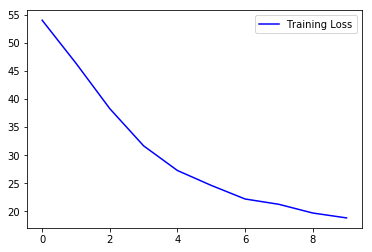

In [12]:
plt.plot(train_loss_history, color = 'b', label = 'Training Loss')
plt.legend()
plt.show()

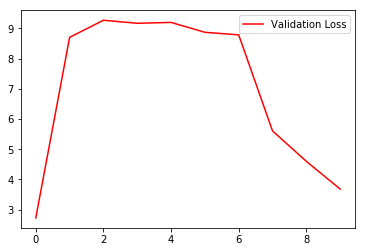

In [13]:
plt.plot(val_loss_history, color = 'r', label = 'Validation Loss')
plt.legend()
plt.show()

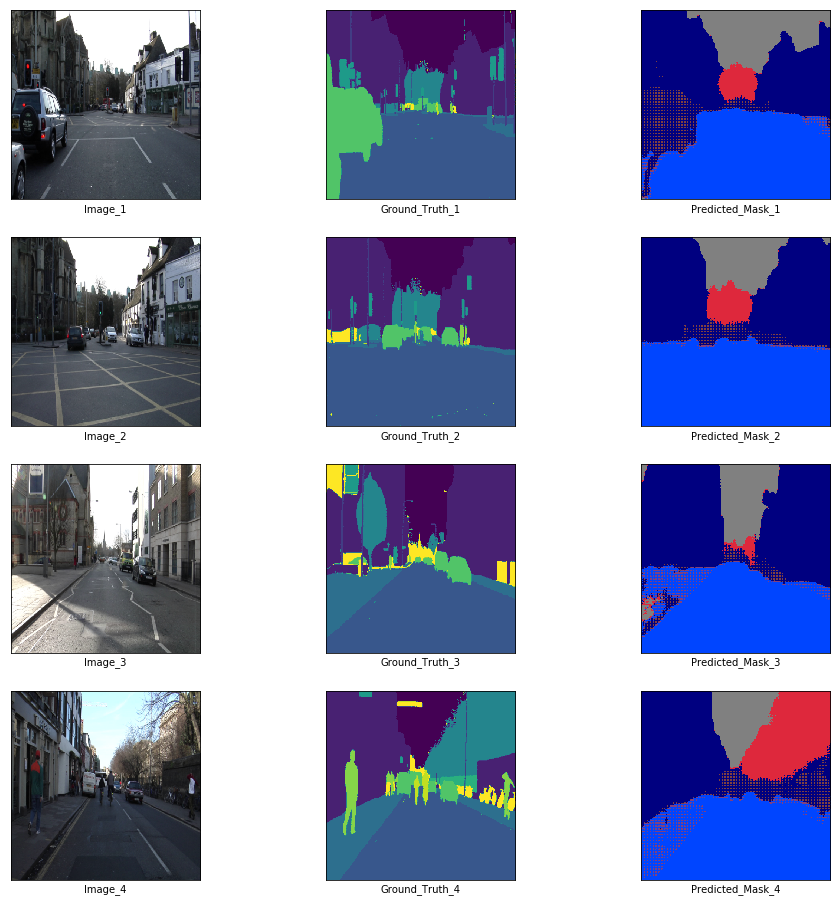

In [14]:
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (16, 16))
plt.setp(axes.flat, xticks = [], yticks = [])
c = 1
for i, ax in enumerate(axes.flat):
    if i % 3 == 0:
        ax.imshow(ToPILImage()(x_batch[c]))
        ax.set_xlabel('Image_' + str(c))
    elif i % 3 == 1:
        ax.imshow(y_batch[c])
        ax.set_xlabel('Ground_Truth_' + str(c))
    elif i % 3 == 2:
        ax.imshow(predict_rgb(enet, x_batch[c].unsqueeze(0).to(device)))
        ax.set_xlabel('Predicted_Mask_' + str(c))
        c += 1
plt.show()